<h1><font color="#113D68" size=6>Deep Learning con Python y Keras</font></h1>

<h1><font color="#113D68" size=5>Parte 6. Redes Neuronales Recurrentes</font></h1>

<h1><font color="#113D68" size=4>3. LSTM para Regresión</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo Cara</font><br>

</div>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>

* [0. Contexto](#section0)
* [1. LSTM para regresión](#section1)
    * [1.1. Cargar el dataset](#section1.1)
    * [1.2. Normalización de datos](#section1.2)
    * [1.3. Train/Test](#section1.3)
    * [1.4. Creamos el dataset para una serie temporal](#section1.4)
    * [1.5. Transformar las muestras](#section1.5)
    * [1.6. Diseño de LSTM](#section1.6)
    * [1.7. Resultados](#section1.7)
* [2. LSTM usando ventana](#section2)
* [3. LSTM con pasos de tiempo](#section3)
* [4. LSTM con memoria entre batchs](#section4)
    * [4.1. Generar estado en train](#section4.1)
    * [4.2. Diseño de LSTM](#section4.2)
* [5. Stacked LSTM con memoria entre batchs](#section5)

---
<a id="section0"></a>
# <font color="#004D7F" size=6> 0. Contexto</font>

La red LSTM es un tipo de red neuronal recurrente que se utiliza en el Deep Learning porque se pueden entrenar con éxito arquitecturas muy grandes.

Por tanto, en esta lección trabajaremos:
* Desarrollar LSTM para un problema de regresión con secuencialidad temporal.
* Desarrollar redes LSTM usando una ventana y pasos de tiempo.
* Desarrollar y hacer predicciones que mantienen el estado (memoria) en secuencias muy largas.

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section1"></a>
# <font color="#004D7F" size=6>1. LSTM para regresión</font>

El problema que veremos en esta lección es el problema de predicción de pasajeros de aerolíneas internacionales.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Más información sobre el dataset [Air Passengers](https://www.kaggle.com/chirag19/air-passengers)

<a id="section1.1"></a>
# <font color="#004D7F" size=5>1.1. Cargar el dataset</font>

Cargamos el dataset

In [1]:
# El dataset tiene en miles el número de pasajeros por mes (queremos predecir su valor en función del tiempo)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# Convierto el array de valores en una matriz del dataset
def create_dataset(dataset, look_back=1): # look_back es el número de ventana temporal (si es 3, tenemos 3 períodos de tiempo: t-2,t-1 y t para predecir sobre el instante t+1)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Cargo el dataset
dataframe = pd.read_csv('data/international-airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
dataframe

# Usamos como índice cada mes desde enero de 1949 hasta diciembre de 1960 y como única característica a predecir el número de pasajeros en miles

,Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


<a id="section1.2"></a>
# <font color="#004D7F" size=5>1.2. Normalización de datos</font>

Las LSTM son sensibles a la escala de los datos de entrada, específicamente cuando se utilizan las funciones de activación Sigmoidea (predeterminada) o Tanh, por lo que una normalización nos otroga resultados más prometedores.

In [2]:
# Las LSTM son sensibles a la escala de los datos de entrada, más si usamos una función sigmoidal (predeterminada) o Tahn
# Normalizamos el dataset (buena práctica)
scaler = MinMaxScaler(feature_range=(0,1)) # ponemos el rango de las características entre 0 y 1
dataset = scaler.fit_transform(dataset) # aplicamos normalización al dataset

<a id="section1.3"></a>
# <font color="#004D7F" size=5>1.3. Train/Test</font>

Dividimos el conjunto de datos en train/test

In [3]:
# Dividimos el set en train/test (con arrays es así)
train_size = int(len(dataset)*0.67)
test_size = len(dataset) - train_size
train,test = dataset [0:train_size, :], dataset[train_size:len(dataset),:] # dividimos a las instancias en 67/33 para train/test

<a id="section1.4"></a>
# <font color="#004D7F" size=5>1.4. Creamos el dataset para una serie temporal</font>

Utilizamos la funcion `create_dataset()` para adaptar nuestro dataset a una serie temporal

In [4]:
# Remodelo en X=t e Y=t+1 (tamaño de ventana = 1)
look_back = 1 # tamaño de ventana de tiempo 
trainX,trainY = create_dataset(train,look_back)
testX,testY = create_dataset(test,look_back)


<a id="section1.5"></a>
# <font color="#004D7F" size=5>1.5. Transformar las muestras</font>

La red LSTM espera que los datos de entrada (X) se proporcionen con una estructura de matriz específica en forma de: $[muestras,\ pasos\ de\ tiempo,\ características]$. 

Nuestros datos preparados tienen la forma: $[muestras,\ características]$ por lo que requiere esta transformación.

In [5]:
# LSTM espera matriz de [muestras, pasos de tiempo, características] y a nuestros datos preparados le faltan los pasos de tiempo
# Ver con trainX.shape que solo vemos muestras y características. En este caso los pasos de tiempo es igual a 1 (tamaño de ventana)
# Remodelo el input para que sea [muestras, pasos de tiempo, características]
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1])) # ponemos las muestras, tamaño de ventana y número de características que tenemos
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1]))

In [6]:
trainX.shape # ahora tenemos 3 componentes del array

(94, 1, 1)

<a id="section1.6"></a>
# <font color="#004D7F" size=5>1.6. Diseño de LSTM</font>

Creamos nuestra LSTM:
1. Una capa visible con 1 entrada
2. Una capa oculta con 4 bloques LSTM o neuronas
3. Una capa de salida que hace una predicción de valor único. LSTM utiliza por defecto la función Sigmoidal.
4. Entrenamos para 100 épocas y el tamaño de batch a 1.

In [7]:
# Creamos la red LSTM
model = Sequential()
model.add(LSTM(4,input_shape=(1,look_back))) # Primera capa oculta con 4 bloques LSTM (neuronas) con 1 entrada y su tamaño de ventana. Ahora no es input_dim sino input_shape
model.add(Dense(1)) # Capa de salida que predice un único valor

# Compilamos y Entrenamos el modelo
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2) # 100 épocas de entrenamiento y batch_size de 1

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
94/94 - 3s - 29ms/step - loss: 0.0469
Epoch 2/100
94/94 - 0s - 1ms/step - loss: 0.0256
Epoch 3/100
94/94 - 0s - 1ms/step - loss: 0.0189
Epoch 4/100
94/94 - 0s - 1ms/step - loss: 0.0172
Epoch 5/100
94/94 - 0s - 1ms/step - loss: 0.0164
Epoch 6/100
94/94 - 0s - 1ms/step - loss: 0.0159
Epoch 7/100
94/94 - 0s - 1ms/step - loss: 0.0151
Epoch 8/100
94/94 - 0s - 1ms/step - loss: 0.0144
Epoch 9/100
94/94 - 0s - 1ms/step - loss: 0.0137
Epoch 10/100
94/94 - 0s - 1ms/step - loss: 0.0129
Epoch 11/100
94/94 - 0s - 1ms/step - loss: 0.0121
Epoch 12/100
94/94 - 0s - 1ms/step - loss: 0.0114
Epoch 13/100
94/94 - 0s - 1ms/step - loss: 0.0105
Epoch 14/100
94/94 - 0s - 1ms/step - loss: 0.0097
Epoch 15/100
94/94 - 0s - 1ms/step - loss: 0.0089
Epoch 16/100
94/94 - 0s - 1ms/step - loss: 0.0080
Epoch 17/100
94/94 - 0s - 1ms/step - loss: 0.0073
Epoch 18/100
94/94 - 0s - 1ms/step - loss: 0.0064
Epoch 19/100
94/94 - 0s - 1ms/step - loss: 0.0057
Epoch 20/100
94/94 - 0s - 1ms/step - loss: 0.0051
Epoch 21

<a id="section1.7"></a>
# <font color="#004D7F" size=5>1.7. Resultados</font>

A continuación se representa el cógido para representar los resultados.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Puntuación Entrenamiento: 22.79 RMSE
Puntuación Validación: 49.10 RMSE


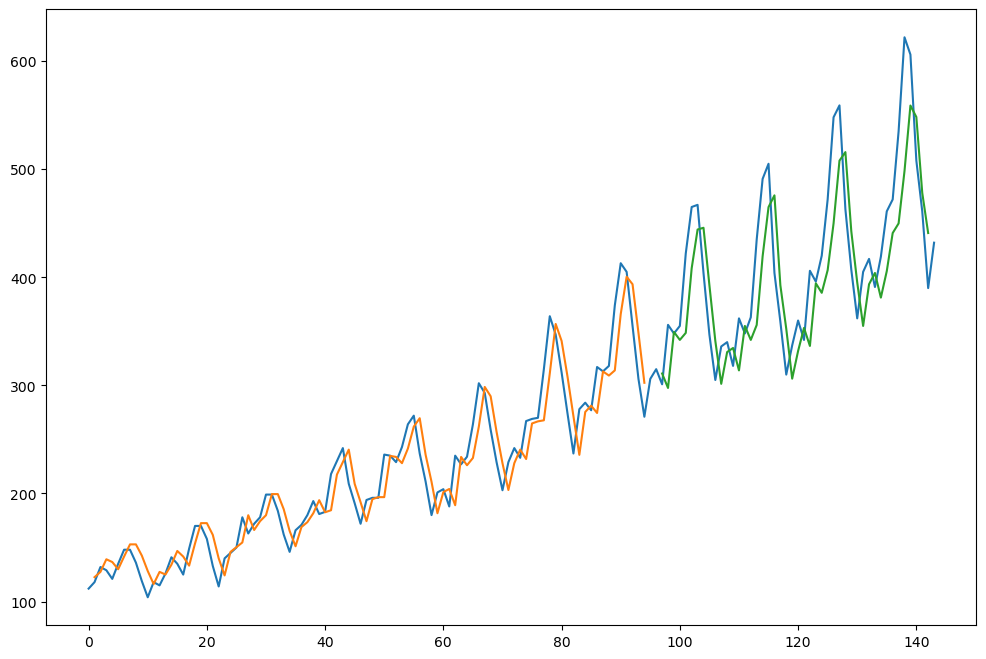

In [8]:
# Hacemos predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invertimos las predicciones (pasamos los valores normalizados que predice el modelo a valores reales en el contexto del problema)
trainPredict = scaler.inverse_transform(trainPredict) # invierto lo que hice con el objeto scaler que habia declarado antes (para pasar de datos reales a normalizados)
trainY = scaler.inverse_transform([trainY]) # estos 2 para train
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY]) # estos 2 para test

# Calculamos el Error Cuadrático Medio
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0])) # comparamos lo predicho con lo real en entrenamiento
print('Puntuación Entrenamiento: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0])) # comparamos lo predicho con lo real en el testeo
print('Puntuación Validación: %.2f RMSE' % (testScore))

# Reformateamos las predicciones del entrenamiento para poder graficar
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(trainPredict)+look_back, :] = trainPredict

# Reformateamos las predicciones del testeo para poder graficar
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict) + (look_back*2) + 1 : len(dataset) - 1, :] = testPredict


# Graficamos las predicciones
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Si no nos anda ejecutar todo el código de vuelta (problema de reformateos en el camino)
# En naranja (train) y verde (validación) vemos el ajuste del modelo a los datos reales (azul), teniendo un mayor erorr de los datos de validación con respecto a los de entrenamiento 
# Tenemos un leve Underffiting, por lo que es recomendable seguir entrenando y ajustando el modelo (falla en promedio sobre 22750 pasajeros en entrenamiento y sobre 48350 en test)

Podemos ver que el modelo tiene un error promedio de aproximadamente 23 pasajeros (en miles) en el conjunto de datos de entrenamiento y aproximadamente 52 pasajeros (en miles) en el conjunto de datos de prueba. 

No está tan mal pero vamos a intentar mejorarlo

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section2"></a>
# <font color="#004D7F" size=6>2. LSTM usando ventana</font>

Recordemos lo que estuviemos viendo, dado el tiempo actual _(t)_ que queremos predecir el valor en el próximo tiempo en la secuencia _(t + 1),_ podemos usar el tiempo actual _(t)_ así como los dos tiempos anteriores _(t-1_ y _t-2)_ como variables de entrada. Cuando se expresa como un problema de regresión, las variables de entrada son _t-2, t-1, t_ y la variable de salida es _t + 1._

Este proceso quedaría:
```
    X1  X2  X3  Y
    112 118 132 129
    118 132 129 121
    132 129 121 135
    129 121 135 148
    121 135 148 148 
```

Por tanto únicamente cambiamos el tamaño de ventana al proceso realizado anteriormente con la función `create_dataset()`.

Epoch 1/100


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 - 2s - 23ms/step - loss: 0.0459
Epoch 2/100
92/92 - 0s - 1ms/step - loss: 0.0195
Epoch 3/100
92/92 - 0s - 1ms/step - loss: 0.0134
Epoch 4/100
92/92 - 0s - 1ms/step - loss: 0.0116
Epoch 5/100
92/92 - 0s - 1ms/step - loss: 0.0105
Epoch 6/100
92/92 - 0s - 1ms/step - loss: 0.0092
Epoch 7/100
92/92 - 0s - 1ms/step - loss: 0.0083
Epoch 8/100
92/92 - 0s - 1ms/step - loss: 0.0073
Epoch 9/100
92/92 - 0s - 1ms/step - loss: 0.0066
Epoch 10/100
92/92 - 0s - 1ms/step - loss: 0.0060
Epoch 11/100
92/92 - 0s - 1ms/step - loss: 0.0054
Epoch 12/100
92/92 - 0s - 1ms/step - loss: 0.0051
Epoch 13/100
92/92 - 0s - 1ms/step - loss: 0.0048
Epoch 14/100
92/92 - 0s - 1ms/step - loss: 0.0046
Epoch 15/100
92/92 - 0s - 1ms/step - loss: 0.0044
Epoch 16/100
92/92 - 0s - 1ms/step - loss: 0.0043
Epoch 17/100
92/92 - 0s - 1ms/step - loss: 0.0042
Epoch 18/100
92/92 - 0s - 1ms/step - loss: 0.0042
Epoch 19/100
92/92 - 0s - 1ms/step - loss: 0.0042
Epoch 20/100
92/92 - 0s - 1ms/step - loss: 0.0040
Epoch 21/100
92/92 -

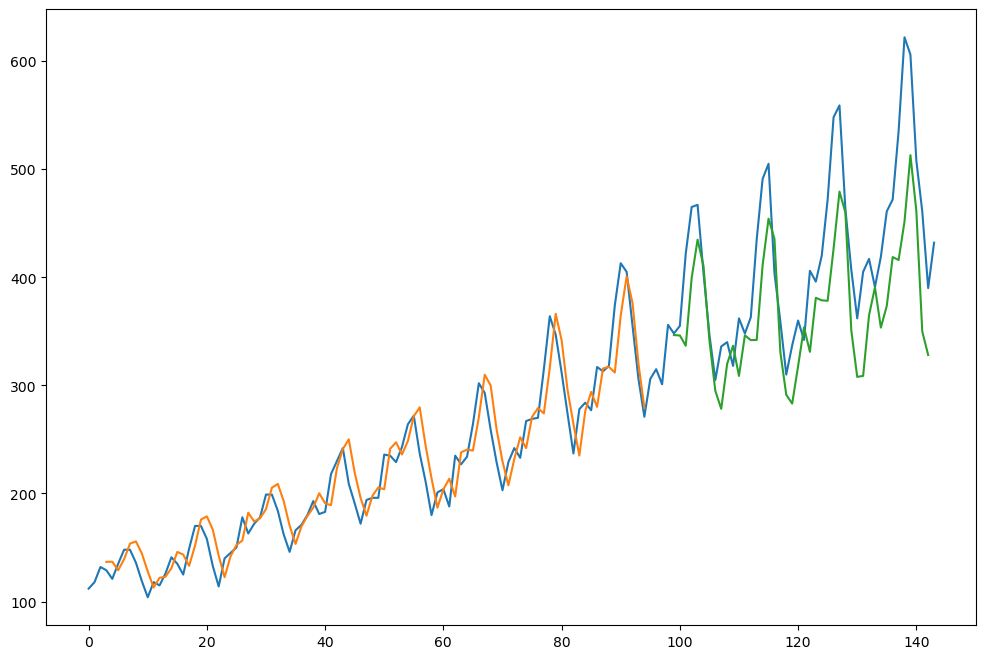

In [9]:
# En el modelo anterior, intentabamos predecir en el instante t+1 usando la información del instante t
# Vamos a intentar mejorar el modelo utilizando un tamaño de ventana mayor a 1 (ventana=1 es usar el instante t para predecir en t+1)
# Usamos el instante t-2,t-1 y t para predecir en el instante t+1 (tamaño de ventana=3). Utilizo 2 instantes más anteriores que en el caso del modelo anterior

# Remodelo en X=t e Y=t+1 (tamaño de ventana = 3)
look_back = 3 # tamaño de ventana de tiempo (incluidas en X=t)
trainX,trainY = create_dataset(train,look_back)
testX,testY = create_dataset(test,look_back)

# Remodelo la entrada para que sea [muestras, pasos de tiempo, características]. Pasos de tiempo siguen quedando en 1
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1])) # ponemos las muestras, tamaño de ventana y número de características que tenemos
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1]))


# Creamos la red LSTM. Queda igual solo que ahora el valor de look_back es diferente
model = Sequential()
model.add(LSTM(4,input_shape=(1,look_back))) # Primera capa oculta con 4 bloques LSTM (neuronas) con 1 entrada y su tamaño de ventana. Ahora no es input_dim sino input_shape
model.add(Dense(1)) # Capa de salida que predice un único valor

# Compilamos y Entrenamos el modelo
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2) # 100 épocas de entrenamiento y batch_size de 1

# Hacemos predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invertimos las predicciones (pasamos los valores normalizados que predice el modelo a valores reales en el contexto del problema)
trainPredict = scaler.inverse_transform(trainPredict) # invierto lo que hice con el objeto scaler que habia declarado antes (para pasar de datos reales a normalizados)
trainY = scaler.inverse_transform([trainY]) # estos 2 para train
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY]) # estos 2 para test

# Calculamos el Error Cuadrático Medio
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0])) # comparamos lo predicho con lo real en entrenamiento
print('Puntuación Entrenamiento: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0])) # comparamos lo predicho con lo real en el testeo
print('Puntuación Validación: %.2f RMSE' % (testScore))

# Reformateamos las predicciones del entrenamiento para poder graficar
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(trainPredict)+look_back, :] = trainPredict

# Reformateamos las predicciones del testeo para poder graficar
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict) + (look_back*2) + 1 : len(dataset) - 1, :] = testPredict


# Graficamos las predicciones
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Vemos que los resultados empeoran con respecto al modelo anterior, y que en este caso no es conveniente establecer una ventana temporal en 3 instantes para la predicción
# Falla en mayores miles de pasajeros para predecir

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section3"></a>
# <font color="#004D7F" size=6>3. LSTM con pasos de tiempo</font>

En lugar de redactar las observaciones pasadas como características de entrada separadas, podemos usarlas como pasos de tiempo de la característica de una entrada, que de hecho es un encuadre más preciso del problema. Podemos hacer esto usando la misma representación de datos que en el ejemplo anterior basado en ventanas, excepto que cuando cambiamos la forma de los datos, configuramos las columnas para que sean la dimensión de pasos de tiempo y cambiamos la dimensión de características de nuevo a 1. 

```python
    trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
```

Epoch 1/100


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 - 2s - 26ms/step - loss: 0.0377
Epoch 2/100
92/92 - 0s - 1ms/step - loss: 0.0174
Epoch 3/100
92/92 - 0s - 1ms/step - loss: 0.0147
Epoch 4/100
92/92 - 0s - 1ms/step - loss: 0.0131
Epoch 5/100
92/92 - 0s - 1ms/step - loss: 0.0115
Epoch 6/100
92/92 - 0s - 2ms/step - loss: 0.0102
Epoch 7/100
92/92 - 0s - 1ms/step - loss: 0.0088
Epoch 8/100
92/92 - 0s - 2ms/step - loss: 0.0079
Epoch 9/100
92/92 - 0s - 1ms/step - loss: 0.0066
Epoch 10/100
92/92 - 0s - 1ms/step - loss: 0.0057
Epoch 11/100
92/92 - 0s - 1ms/step - loss: 0.0050
Epoch 12/100
92/92 - 0s - 1ms/step - loss: 0.0044
Epoch 13/100
92/92 - 0s - 1ms/step - loss: 0.0042
Epoch 14/100
92/92 - 0s - 1ms/step - loss: 0.0042
Epoch 15/100
92/92 - 0s - 2ms/step - loss: 0.0040
Epoch 16/100
92/92 - 0s - 1ms/step - loss: 0.0039
Epoch 17/100
92/92 - 0s - 1ms/step - loss: 0.0039
Epoch 18/100
92/92 - 0s - 1ms/step - loss: 0.0038
Epoch 19/100
92/92 - 0s - 2ms/step - loss: 0.0038
Epoch 20/100
92/92 - 0s - 1ms/step - loss: 0.0038
Epoch 21/100
92/92 -

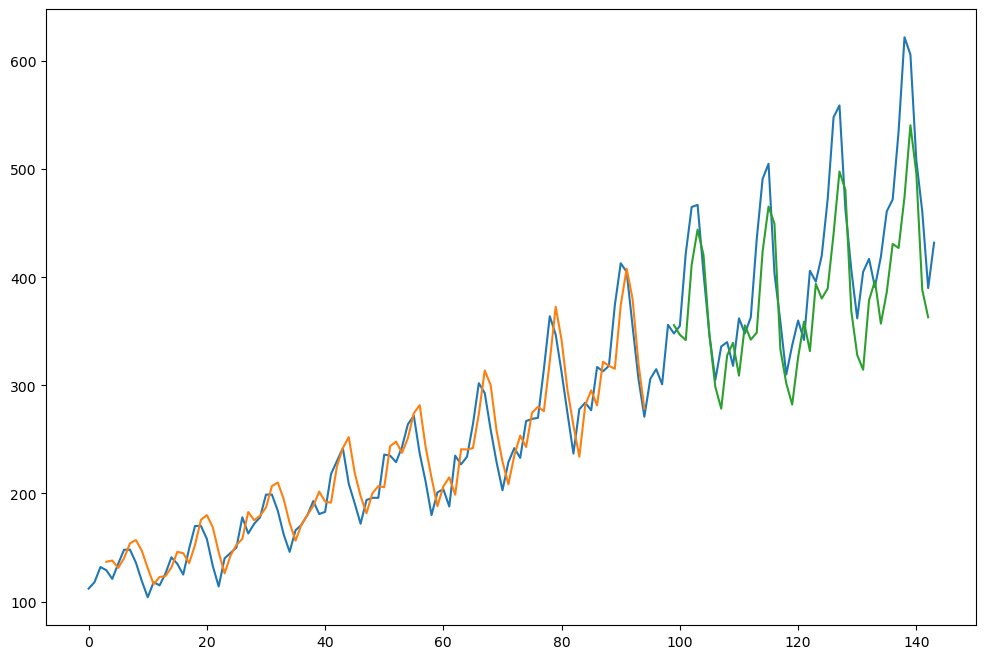

In [10]:
# Algunos problemas de secuencia deben tener un número variado de pasos de tiempo por muestra
# Ahora al modelo anterior le sumamos la configuración de que las columnas sean de tamaño de la dimensión de pasos de tiempo y la dimensión de las características sean 1

# Remodelo en X=t e Y=t+1 (tamaño de ventana = 3)
look_back = 3 # tamaño de ventana de tiempo (incluidas en X=t)
trainX,trainY = create_dataset(train,look_back)
testX,testY = create_dataset(test,look_back)

# Remodelo la entrada para que sea [muestras, pasos de tiempo, características]. Los pasos de tiempo ahora son del número de vantanas de tiempo utilizadas para predecir (en este caso 3) y nuestras características las establecemos en 1
# Recordemos que shape nos muestra las dimensiones de los datos de entrenamiento y test (que con ventana = 3 nos quedarian de 92x3 para test por ej)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


# Creamos la red LSTM. Ahora el input_shape va a cambiar (tamaño ventana, 1 característica)
model = Sequential()
model.add(LSTM(4,input_shape=(look_back,1))) # Primera capa oculta con 4 bloques LSTM (neuronas) con 1 entrada y su tamaño de ventana. Ahora no es input_dim sino input_shape
model.add(Dense(1)) # Capa de salida que predice un único valor

# Compilamos y Entrenamos el modelo
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2) # 100 épocas de entrenamiento y batch_size de 1

# Hacemos predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invertimos las predicciones (pasamos los valores normalizados que predice el modelo a valores reales en el contexto del problema)
trainPredict = scaler.inverse_transform(trainPredict) # invierto lo que hice con el objeto scaler que habia declarado antes (para pasar de datos reales a normalizados)
trainY = scaler.inverse_transform([trainY]) # estos 2 para train
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY]) # estos 2 para test

# Calculamos el Error Cuadrático Medio
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0])) # comparamos lo predicho con lo real en entrenamiento
print('Puntuación Entrenamiento: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0])) # comparamos lo predicho con lo real en el testeo
print('Puntuación Validación: %.2f RMSE' % (testScore))

# Reformateamos las predicciones del entrenamiento para poder graficar
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(trainPredict)+look_back, :] = trainPredict

# Reformateamos las predicciones del testeo para poder graficar
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict) + (look_back*2) + 1 : len(dataset) - 1, :] = testPredict


# Graficamos las predicciones
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Vemos que el nuevo modelo mejora un poco los resultados del modelo anterior (pareciera más recomendable que si cambiamos la ventana de tiempo también cambiemos los pasos de tiempo)
# Pero no mejora los resultados del primer modelo (con ventana=1 y pasos de tiempo=1 en vez de ambos con 3)

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section4"></a>
# <font color="#004D7F" size=6>4. LSTM con memoria entre batchs</font>

La red LSTM tiene memoria que es capaz de recordar secuencias largas. 

<a id="section4.1"></a>
# <font color="#004D7F" size=5>4.1. Generar estado en train</font>

Normalmente, el estado dentro de la red se restablece después de cada batch, así como con cada llamada a `model.predict()` o `model.evaluate()`. Podemos obtener un control más preciso sobre cuándo se borra el estado interno de la red LSTM haciendo que la capa LSTM tenga estado (parámetro `stateful`). 

Por tanto, requerimos que los datos de entrenamiento no se mezclen al ajustar la red y un restablecimiento explícito del estado de la red después época mediante llamadas a la función `model.reset states()`.

In [11]:
# Le añadimos a la red LSTM la posibilidad de tener un estado (capacidad de memoria, propia de la red para que alacene y recuerde)
# Significa que puede generar un estado en toda la secuencia de entrenamiento e incluso mantenerlo si es necesario para hacer predicciones
# Para aplicarlo debemos crear nuestro propio bucle externo de épocas, y dentro de cada una llamar tanto al fit() como al reset states() para borrar estados anteriores

# Remodelo en X=t e Y=t+1 (tamaño de ventana = 3)
look_back = 3 # tamaño de ventana de tiempo (incluidas en X=t)
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
     
# Remodelo la entrada para que sea [muestras, pasos de tiempo, características] (seguimos usando los pasos de tiempo = 3)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
     
# Creamos y Entrenamos la nueva red LSTM
batch_size = 1
model = Sequential()
#model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(LSTM(4, stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100): # ahora no especificamos las épocas con el parámetro, sino con un bucle
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_metrics()

# Con esto ya tenemos entrenada la red neuronal

92/92 - 2s - 26ms/step - loss: 0.0053
92/92 - 0s - 2ms/step - loss: 0.0181
92/92 - 0s - 2ms/step - loss: 0.0125
92/92 - 0s - 2ms/step - loss: 0.0096
92/92 - 0s - 1ms/step - loss: 0.0077
92/92 - 0s - 1ms/step - loss: 0.0065
92/92 - 0s - 1ms/step - loss: 0.0058
92/92 - 0s - 1ms/step - loss: 0.0053
92/92 - 0s - 1ms/step - loss: 0.0050
92/92 - 0s - 1ms/step - loss: 0.0048
92/92 - 0s - 2ms/step - loss: 0.0047
92/92 - 0s - 1ms/step - loss: 0.0045
92/92 - 0s - 1ms/step - loss: 0.0044
92/92 - 0s - 1ms/step - loss: 0.0044
92/92 - 0s - 2ms/step - loss: 0.0043
92/92 - 0s - 1ms/step - loss: 0.0042
92/92 - 0s - 1ms/step - loss: 0.0041
92/92 - 0s - 1ms/step - loss: 0.0041
92/92 - 0s - 1ms/step - loss: 0.0040
92/92 - 0s - 1ms/step - loss: 0.0040
92/92 - 0s - 1ms/step - loss: 0.0039
92/92 - 0s - 1ms/step - loss: 0.0038
92/92 - 0s - 1ms/step - loss: 0.0038
92/92 - 0s - 1ms/step - loss: 0.0037
92/92 - 0s - 1ms/step - loss: 0.0037
92/92 - 0s - 1ms/step - loss: 0.0036
92/92 - 0s - 1ms/step - loss: 0.0036


<a id="section4.2"></a>
# <font color="#004D7F" size=5>4.2. Diseño de LSTM</font>

Finalmente, cuando se construye la capa LSTM, el parámetro `stateful` debe establecerse en `True` y, en lugar de especificar,mediante el parámetro `batch_input_shape`:
1. Las dimensiones de entrada
2. Codificar el número de muestras en un batch
3. El número de pasos de tiempo en una muestra y 
4. El número de características en un paso de tiempo. 

Por ejemplo: 
```python
    model.add(LSTM(4, batch_input_shape = (batch_size, look_back, 1), stateful = True))
```

Este mismo tamaño de batch debe usarse más adelante al evaluar el modelo y hacer predicciones. 

```python
    model.predict(trainX, batch_size = batch_size)
```

92/92 - 3s - 29ms/step - loss: 0.0058
92/92 - 0s - 2ms/step - loss: 0.0095
92/92 - 0s - 2ms/step - loss: 0.0076
92/92 - 0s - 2ms/step - loss: 0.0069
92/92 - 0s - 2ms/step - loss: 0.0064
92/92 - 0s - 1ms/step - loss: 0.0061
92/92 - 0s - 2ms/step - loss: 0.0059
92/92 - 0s - 2ms/step - loss: 0.0057
92/92 - 0s - 1ms/step - loss: 0.0055
92/92 - 0s - 2ms/step - loss: 0.0054
92/92 - 0s - 2ms/step - loss: 0.0052
92/92 - 0s - 1ms/step - loss: 0.0051
92/92 - 0s - 1ms/step - loss: 0.0050
92/92 - 0s - 1ms/step - loss: 0.0049
92/92 - 0s - 1ms/step - loss: 0.0048
92/92 - 0s - 2ms/step - loss: 0.0047
92/92 - 0s - 2ms/step - loss: 0.0046
92/92 - 0s - 2ms/step - loss: 0.0045
92/92 - 0s - 2ms/step - loss: 0.0045
92/92 - 0s - 2ms/step - loss: 0.0044
92/92 - 0s - 1ms/step - loss: 0.0043
92/92 - 0s - 1ms/step - loss: 0.0042
92/92 - 0s - 1ms/step - loss: 0.0042
92/92 - 0s - 2ms/step - loss: 0.0041
92/92 - 0s - 1ms/step - loss: 0.0040
92/92 - 0s - 1ms/step - loss: 0.0040
92/92 - 0s - 2ms/step - loss: 0.0039


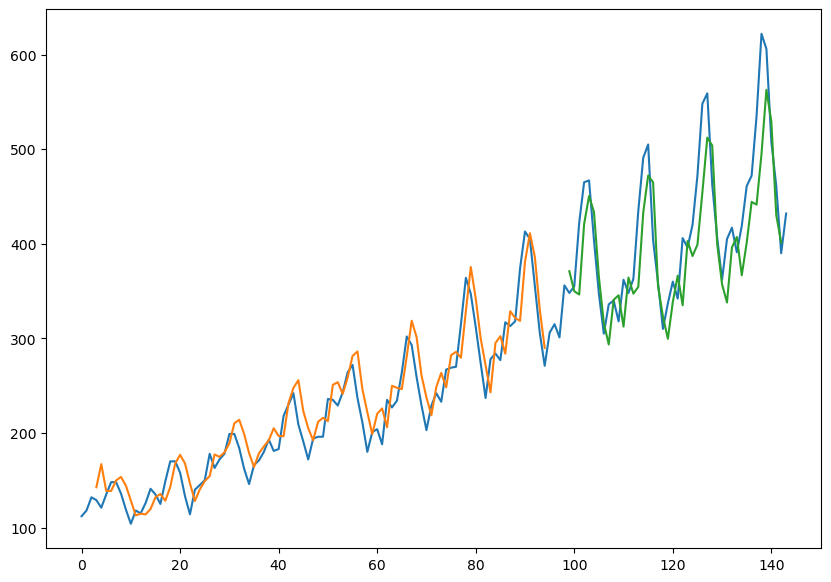

In [12]:
# Ahora entrenamos el modelo y realizamos las predicciones (el código completo es el siguiente)

# Remodelo en X=t e Y=t+1 (tamaño de ventana = 3)
look_back = 3 # tamaño de ventana de tiempo (incluidas en X=t)
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
     
# Remodelo la entrada para que sea [muestras, pasos de tiempo, características] (seguimos usando los pasos de tiempo = 3)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
     
# Creamos y Entrenamos la nueva red LSTM
batch_size = 1
model = Sequential()
#model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(LSTM(4, stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100): # ahora no especificamos las épocas con el parámetro, sino con un bucle
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_metrics()

# Hacemos predicciones
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_metrics() # borramos o reseteamos los estados para que no influya en el test predict
testPredict = model.predict(testX, batch_size=batch_size)
     
# Invertimos las predicciones (pasamos los valores normalizados que predice el modelo a valores reales en el contexto del problema)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
     
# Calculamos el Error Cuadrático Medio
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
  
# Reformateamos las predicciones del entrenamiento para poder graficar
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
     
# Reformateamos las predicciones del testeo para poder graficar
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
     
# Graficamos las predicciones
plt.figure(figsize=(10,7))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Vemos que de todos los modelos es el que menos error tiene en el test, sin necesariamente ser el que menos error tiene en el train
# A lo mejor entrenando el modelo en más épocas puede internalizar el problema, o con más módulos también podemos probar (más capas ocultas/LSTM o neuronas por capas)

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section5"></a>
# <font color="#004D7F" size=6>5. Stacked LSTM con memoria entre batchs</font>

Las redes LSTM se pueden apilar de la misma manera que se pueden apilar otros tipos de capas. Una adición a la configuración que se requiere es que una capa LSTM antes de cada capa LSTM subsiguiente debe devolver la secuencia. 

Esto se puede hacer configurando el parámetro `return_sequences` en la capa a `True`.

```python
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
```

92/92 - 4s - 46ms/step - loss: 0.0064
92/92 - 0s - 2ms/step - loss: 0.0197
92/92 - 0s - 2ms/step - loss: 0.0156
92/92 - 0s - 2ms/step - loss: 0.0130
92/92 - 0s - 2ms/step - loss: 0.0114
92/92 - 0s - 2ms/step - loss: 0.0103
92/92 - 0s - 2ms/step - loss: 0.0095
92/92 - 0s - 2ms/step - loss: 0.0089
92/92 - 0s - 2ms/step - loss: 0.0085
92/92 - 0s - 2ms/step - loss: 0.0081
92/92 - 0s - 2ms/step - loss: 0.0078
92/92 - 0s - 2ms/step - loss: 0.0075
92/92 - 0s - 2ms/step - loss: 0.0072
92/92 - 0s - 2ms/step - loss: 0.0069
92/92 - 0s - 2ms/step - loss: 0.0067
92/92 - 0s - 2ms/step - loss: 0.0065
92/92 - 0s - 2ms/step - loss: 0.0062
92/92 - 0s - 2ms/step - loss: 0.0060
92/92 - 0s - 2ms/step - loss: 0.0058
92/92 - 0s - 2ms/step - loss: 0.0057
92/92 - 0s - 2ms/step - loss: 0.0055
92/92 - 0s - 2ms/step - loss: 0.0053
92/92 - 0s - 2ms/step - loss: 0.0052
92/92 - 0s - 2ms/step - loss: 0.0050
92/92 - 0s - 2ms/step - loss: 0.0049
92/92 - 0s - 2ms/step - loss: 0.0047
92/92 - 0s - 2ms/step - loss: 0.0046


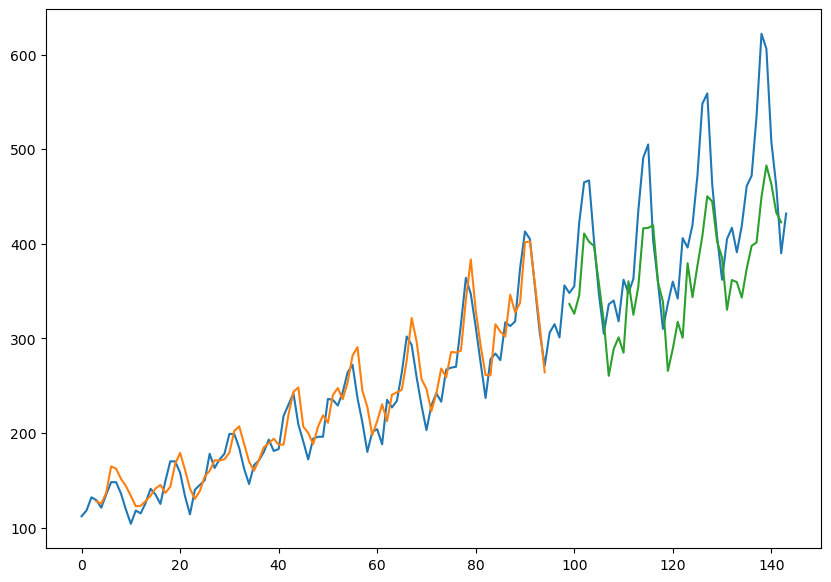

In [15]:
# Este tipo de modelado puede ser exitoso con redes que poseen mucha profundidad, específicamente para una red con más de una capa LSTM (probar para patrones más complejos)
# A la capa LSTM anterior a la capa LSTM subsiguiente se le debe agregar el return_sequences=True. Seguimos con el mismo look_back y Reshape (3 pasos de tiempo)

# Remodelo en X=t e Y=t+1 (tamaño de ventana = 3)
look_back = 3 # tamaño de ventana de tiempo (incluidas en X=t)
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
     
# Remodelo la entrada para que sea [muestras, pasos de tiempo, características] (seguimos usando los pasos de tiempo = 3)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
     
# Creamos y Entrenamos la nueva red LSTM
batch_size = 1
model = Sequential()
#model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(LSTM(4, stateful=True, return_sequences=True)) # que el estado en que se encuentra esta capa LSTM me lo devuelva/pase a la siguiente
model.add(LSTM(4, stateful=True)) # Segunda capa LSTM. Recuerda la secuencia de la anterior
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100): # ahora no especificamos las épocas con el parámetro, sino con un bucle
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_metrics()

# Hacemos predicciones
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_metrics() # borramos o reseteamos los estados para que no influya en el test predict
testPredict = model.predict(testX, batch_size=batch_size)
     
# Invertimos las predicciones (pasamos los valores normalizados que predice el modelo a valores reales en el contexto del problema)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
     
# Calculamos el Error Cuadrático Medio
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
  
# Reformateamos las predicciones del entrenamiento para poder graficar
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
     
# Reformateamos las predicciones del testeo para poder graficar
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
     
# Graficamos las predicciones
plt.figure(figsize=(10,7))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Vemos que de todos los modelos, este es el que menor error posee con respecto a los datos de entrenamiento
# Sin embargo, el error con respecto al test aumenta considerablemente, produciendo un Overffiting o Sobreajuste del Modelo a los datos de entrenamiento, reduciendo su capacidad de predicción de datos nuevos

<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>